Tests to implement:

1. KDD/GDD biases
2. LH/SH biases
3. Do these biases scale with ag production
4. Do these biases change over the growing season
5. Do historical cmip6 temperature biases predict future changes

In [28]:
import xarray as xr
import xesmf as xe
import numpy as np
import matplotlib.pyplot as plt
import scipy
import statsmodels.api as sm
import cartopy
import cartopy.util
import cartopy.crs as ccrs
import glob
import sys, os
import pickle, gzip
import datetime

In [29]:
run ../util/setupConsole_su

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<Figure size 432x288 with 0 Axes>

In [30]:
dirCmip6 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/CMIP6'
dirERA5 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/ERA5'
dirDeepak = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/data/projects/ag-land-climate/deepak'
dirAgData = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/data/projects/ag-land-climate'
dirProj = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/research/2020-ag-cmip6'

In [31]:
# files = glob.glob('%s/cmip6_output/*.nc'%dirProj)
# for f in files:
#     os.rename(f,'%s.nc'%f[0:-4]) 

In [32]:
with gzip.open('%s/gdd-kdd-lat-era5.dat'%dirAgData, 'rb') as f:
    era5_lat = pickle.load(f)
with gzip.open('%s/gdd-kdd-lon-era5.dat'%dirAgData, 'rb') as f:
    era5_lon = pickle.load(f)

In [33]:
cmip6_models = ['access-cm2', 'access-esm1-5', 'awi-cm-1-1-mr', 'bcc-csm2-mr', 'bcc-esm1', 'canesm5', 'ec-earth3', \
                'gfdl-cm4', 'gfdl-esm4', 'giss-e2-1-g', 'kace-1-0-g', 'fgoals-g3', 'inm-cm5-0', 'ipsl-cm6a-lr', 'miroc6', \
                'mpi-esm1-2-hr', 'mpi-esm1-2-lr', 'mri-esm2-0', 'noresm2-lm', 'noresm2-mm', 'sam0-unicon']

In [34]:
region = 'global'

if region == 'global':
    latRange = [-90, 90]
    lonRange = [0, 360]
elif region == 'us':
    latRange = [20, 57]
    lonRange = [220, 300]
elif region == 'china':
    latRange = [25, 45]
    lonRange = [105, 123]
elif region == 'eu':
    latRange = [38, 56]
    lonRange = [-5, 40]

latIndRange_era5 = np.where((era5_lat >= latRange[0]) & (era5_lat <= latRange[1]))[0]
lonIndRange_era5 = np.where((era5_lon >= lonRange[0]) & (era5_lon <= lonRange[1]))[0]

regridMesh_current = xr.Dataset({'lat': (['lat'], np.arange(latRange[0], latRange[1], 1.5)),
                            'lon': (['lon'], np.arange(lonRange[0], lonRange[1], 1.5)),})

regridMesh_global = xr.Dataset({'lat': (['lat'], np.arange(-90, 90, 1.5)),
                                'lon': (['lon'], np.arange(0, 360, 1.5)),})


if region == 'global':
    regridMesh = regridMesh_global
else:
    regridMesh = regridMesh_current

In [35]:
rebuild = False

if rebuild:
    for m, model in enumerate(cmip6_models):
        print('loading %s'%model)

        if os.path.isfile('cmip6_output/cmip6_tasmax_max_%s_regrid_%s.nc'%(region, cmip6_models[m])):
            print('skipping %s, exists'%cmip6_models[m])
            continue

        if not os.path.isfile('cmip6_output/cmip6_tasmax_max_global_%s.nc'%(cmip6_models[m])):
            print('skipping %s, base file DOESNT EXIST'%cmip6_models[m])
            continue

        ds_global_txx = xr.open_dataset('cmip6_output/cmip6_tasmax_max_global_%s.nc'%cmip6_models[m])
        ds_global_monthly_txx = xr.open_dataset('cmip6_output/cmip6_tasmax_monthly_max_global_%s.nc'%cmip6_models[m])
        ds_global_t50p = xr.open_dataset('cmip6_output/cmip6_tasmax_mean_global_%s.nc'%cmip6_models[m])
        
        # add cyclic point before regridding
        lon_data = cartopy.util.add_cyclic_point(ds_global_txx.lon)
        temp_data = cartopy.util.add_cyclic_point(ds_global_txx.tasmax_max)

        da_global_txx_cyc = xr.DataArray(data   = temp_data, 
                          dims   = ['time', 'lat', 'lon'],
                          coords = {'time':ds_global_txx.time, 'lat':ds_global_txx.lat, 'lon':lon_data},
                          attrs  = {'units'     : 'C'
                            })
        ds_global_txx_cyc = xr.Dataset()
        ds_global_txx_cyc['tasmax_max'] = da_global_txx_cyc
        
        regridder = xe.Regridder(ds_global_txx_cyc, regridMesh, 'bilinear', reuse_weights=True)
        regridder.clean_weight_file()
        ds_global_txx = regridder(ds_global_txx_cyc)

        
        # add cyclic point before regridding
        lon_data = cartopy.util.add_cyclic_point(ds_global_monthly_txx.lon)
        temp_data = cartopy.util.add_cyclic_point(ds_global_monthly_txx.tasmax_monthly_max)

        da_global_monthly_txx_cyc = xr.DataArray(data   = temp_data, 
                          dims   = ['time', 'lat', 'lon'],
                          coords = {'time':ds_global_monthly_txx.time, 'lat':ds_global_monthly_txx.lat, 'lon':lon_data},
                          attrs  = {'units'     : 'C'
                            })
        ds_global_monthly_txx_cyc = xr.Dataset()
        ds_global_monthly_txx_cyc['tasmax_monthly_max'] = da_global_monthly_txx_cyc
        
        regridder = xe.Regridder(ds_global_monthly_txx_cyc, regridMesh, 'bilinear', reuse_weights=True)
        regridder.clean_weight_file()
        ds_global_monthly_txx = regridder(ds_global_monthly_txx_cyc)

        
        # add cyclic point before regridding
        lon_data = cartopy.util.add_cyclic_point(ds_global_t50p.lon)
        temp_data = cartopy.util.add_cyclic_point(ds_global_t50p.tasmax_mean)

        da_global_t50p_cyc = xr.DataArray(data   = temp_data, 
                          dims   = ['time', 'lat', 'lon'],
                          coords = {'time':ds_global_t50p.time, 'lat':ds_global_t50p.lat, 'lon':lon_data},
                          attrs  = {'units'     : 'C'
                            })
        ds_global_t50p_cyc = xr.Dataset()
        ds_global_t50p_cyc['tasmax_mean'] = da_global_t50p_cyc
        
        regridder = xe.Regridder(ds_global_t50p_cyc, regridMesh, 'bilinear', reuse_weights=True)
        regridder.clean_weight_file()
        ds_global_t50p = regridder(ds_global_t50p_cyc)
        
        cmip6_tasmax_max = ds_global_txx.assign_coords({'model':model})
        cmip6_tasmax_monthly_max = ds_global_monthly_txx.assign_coords({'model':model})
        cmip6_tasmax_mean = ds_global_t50p.assign_coords({'model':model})

        cmip6_tasmax_max.to_netcdf('cmip6_output/cmip6_tasmax_max_regrid_%s_%s.nc'%(region, model))
        cmip6_tasmax_monthly_max.to_netcdf('cmip6_output/cmip6_tasmax_monthly_max_regrid_%s_%s.nc'%(region, model))
        cmip6_tasmax_mean.to_netcdf('cmip6_output/cmip6_tasmax_mean_regrid_%s_%s.nc'%(region, model))


In [36]:
cmip6_tasmax_max = xr.Dataset()
cmip6_tasmax_monthly_max = xr.Dataset()
cmip6_tasmax_mean = xr.Dataset()

for m, model in enumerate(cmip6_models):

    print('loading regridded tasmax for %s'%model)

    ds_global_txx = xr.open_dataset('cmip6_output/cmip6_tasmax_max_regrid_%s_%s.nc'%(region, model))
    ds_global_monthly_tx = xr.open_dataset('cmip6_output/cmip6_tasmax_monthly_max_regrid_%s_%s.nc'%(region, model))
    ds_global_t50p = xr.open_dataset('cmip6_output/cmip6_tasmax_mean_regrid_%s_%s.nc'%(region, model))

    if m == 0:
        cmip6_tasmax_max = ds_global_txx
        cmip6_tasmax_monthly_max = ds_global_monthly_tx
        cmip6_tasmax_mean = ds_global_t50p
    else:
        cmip6_tasmax_max = xr.concat([cmip6_tasmax_max, ds_global_txx], dim='model')
        cmip6_tasmax_monthly_max = xr.concat([cmip6_tasmax_monthly_max, ds_global_monthly_tx], dim='model')
        cmip6_tasmax_mean = xr.concat([cmip6_tasmax_mean, ds_global_t50p], dim='model')


loading regridded tasmax for access-cm2
loading regridded tasmax for access-esm1-5
loading regridded tasmax for awi-cm-1-1-mr
loading regridded tasmax for bcc-csm2-mr
loading regridded tasmax for bcc-esm1
loading regridded tasmax for canesm5
loading regridded tasmax for ec-earth3
loading regridded tasmax for gfdl-cm4
loading regridded tasmax for gfdl-esm4
loading regridded tasmax for giss-e2-1-g
loading regridded tasmax for kace-1-0-g
loading regridded tasmax for fgoals-g3
loading regridded tasmax for inm-cm5-0
loading regridded tasmax for ipsl-cm6a-lr
loading regridded tasmax for miroc6
loading regridded tasmax for mpi-esm1-2-hr
loading regridded tasmax for mpi-esm1-2-lr
loading regridded tasmax for mri-esm2-0
loading regridded tasmax for noresm2-lm
loading regridded tasmax for noresm2-mm
loading regridded tasmax for sam0-unicon


In [37]:
rebuild = False


if rebuild:
    for m, model in enumerate(cmip6_models):
        print('loading %s'%model)

        if os.path.isfile('cmip6_output/cmip6_tasmin_max_%s_regrid_%s.nc'%(region, model)):
            print('skipping %s, exists'%cmip6_models[m])
            continue

        if not os.path.isfile('cmip6_output/cmip6_tasmin_max_global_%s.nc'%(model)):
            print('skipping %s, base file DOESNT EXIST'%cmip6_models[m])
            continue

        ds_global_txx = xr.open_dataset('cmip6_output/cmip6_tasmin_max_global_%s.nc'%model)
        ds_global_monthly_txx = xr.open_dataset('cmip6_output/cmip6_tasmin_monthly_max_global_%s.nc'%model)
        ds_global_t50p = xr.open_dataset('cmip6_output/cmip6_tasmin_mean_global_%s.nc'%model)

        # add cyclic point before regridding
        lon_data = cartopy.util.add_cyclic_point(ds_global_txx.lon)
        temp_data = cartopy.util.add_cyclic_point(ds_global_txx.tasmin_max)

        da_global_txx_cyc = xr.DataArray(data   = temp_data, 
                          dims   = ['time', 'lat', 'lon'],
                          coords = {'time':ds_global_txx.time, 'lat':ds_global_txx.lat, 'lon':lon_data},
                          attrs  = {'units'     : 'C'
                            })
        ds_global_txx_cyc = xr.Dataset()
        ds_global_txx_cyc['tasmin_max'] = da_global_txx_cyc
        
        regridder = xe.Regridder(ds_global_txx_cyc, regridMesh, 'bilinear', reuse_weights=True)
        regridder.clean_weight_file()
        ds_global_txx = regridder(ds_global_txx_cyc)

        
        # add cyclic point before regridding
        lon_data = cartopy.util.add_cyclic_point(ds_global_monthly_txx.lon)
        temp_data = cartopy.util.add_cyclic_point(ds_global_monthly_txx.tasmin_monthly_max)

        da_global_monthly_txx_cyc = xr.DataArray(data   = temp_data, 
                          dims   = ['time', 'lat', 'lon'],
                          coords = {'time':ds_global_monthly_txx.time, 'lat':ds_global_monthly_txx.lat, 'lon':lon_data},
                          attrs  = {'units'     : 'C'
                            })
        ds_global_monthly_txx_cyc = xr.Dataset()
        ds_global_monthly_txx_cyc['tasmin_monthly_max'] = da_global_monthly_txx_cyc
        
        regridder = xe.Regridder(ds_global_monthly_txx_cyc, regridMesh, 'bilinear', reuse_weights=True)
        regridder.clean_weight_file()
        ds_global_monthly_txx = regridder(ds_global_monthly_txx_cyc)

        
        # add cyclic point before regridding
        lon_data = cartopy.util.add_cyclic_point(ds_global_t50p.lon)
        temp_data = cartopy.util.add_cyclic_point(ds_global_t50p.tasmin_mean)

        da_global_t50p_cyc = xr.DataArray(data   = temp_data, 
                          dims   = ['time', 'lat', 'lon'],
                          coords = {'time':ds_global_t50p.time, 'lat':ds_global_t50p.lat, 'lon':lon_data},
                          attrs  = {'units'     : 'C'
                            })
        ds_global_t50p_cyc = xr.Dataset()
        ds_global_t50p_cyc['tasmin_mean'] = da_global_t50p_cyc
        
        regridder = xe.Regridder(ds_global_t50p_cyc, regridMesh, 'bilinear', reuse_weights=True)
        regridder.clean_weight_file()
        ds_global_t50p = regridder(ds_global_t50p_cyc)

        cmip6_tasmin_max = ds_global_txx.assign_coords({'model':model})
        cmip6_tasmin_monthly_max = ds_global_monthly_txx.assign_coords({'model':model})
        cmip6_tasmin_mean = ds_global_t50p.assign_coords({'model':model})

        cmip6_tasmin_max.to_netcdf('cmip6_output/cmip6_tasmin_max_regrid_%s_%s.nc'%(region, model))
        cmip6_tasmin_monthly_max.to_netcdf('cmip6_output/cmip6_tasmin_monthly_max_regrid_%s_%s.nc'%(region, model))
        cmip6_tasmin_mean.to_netcdf('cmip6_output/cmip6_tasmin_mean_regrid_%s_%s.nc'%(region, model))


In [38]:
cmip6_tasmin_max = xr.Dataset()
cmip6_tasmin_monthly_max = xr.Dataset()
cmip6_tasmin_mean = xr.Dataset()

for m, model in enumerate(cmip6_models):
    
    if not os.path.isfile('cmip6_output/cmip6_tasmin_max_regrid_%s_%s.nc'%(region, model)):
        print('skipping %s, base file DOESNT EXIST'%model)
        continue
    
    print('loading regridded tasmin for %s'%model)

    ds_global_txx = xr.open_dataset('cmip6_output/cmip6_tasmin_max_regrid_%s_%s.nc'%(region, model))
    ds_global_monthly_tx = xr.open_dataset('cmip6_output/cmip6_tasmin_monthly_max_regrid_%s_%s.nc'%(region, model))
    ds_global_t50p = xr.open_dataset('cmip6_output/cmip6_tasmin_mean_regrid_%s_%s.nc'%(region, model))

    if m == 0:
        cmip6_tasmin_max = ds_global_txx
        cmip6_tasmin_monthly_max = ds_global_monthly_tx
        cmip6_tasmin_mean = ds_global_t50p
    else:
        cmip6_tasmin_max = xr.concat([cmip6_tasmin_max, ds_global_txx], dim='model')
        cmip6_tasmin_monthly_max = xr.concat([cmip6_tasmin_monthly_max, ds_global_monthly_tx], dim='model')
        cmip6_tasmin_mean = xr.concat([cmip6_tasmin_mean, ds_global_t50p], dim='model')


loading regridded tasmin for access-cm2
loading regridded tasmin for access-esm1-5
loading regridded tasmin for awi-cm-1-1-mr
skipping bcc-csm2-mr, base file DOESNT EXIST
loading regridded tasmin for bcc-esm1
loading regridded tasmin for canesm5
loading regridded tasmin for ec-earth3
skipping gfdl-cm4, base file DOESNT EXIST
skipping gfdl-esm4, base file DOESNT EXIST
loading regridded tasmin for giss-e2-1-g
skipping kace-1-0-g, base file DOESNT EXIST
loading regridded tasmin for fgoals-g3
loading regridded tasmin for inm-cm5-0
loading regridded tasmin for ipsl-cm6a-lr
loading regridded tasmin for miroc6
loading regridded tasmin for mpi-esm1-2-hr
loading regridded tasmin for mpi-esm1-2-lr
loading regridded tasmin for mri-esm2-0
loading regridded tasmin for noresm2-lm
loading regridded tasmin for noresm2-mm
skipping sam0-unicon, base file DOESNT EXIST


In [39]:
cmip6_tasmax_max_trend = xr.Dataset()
cmip6_tasmax_monthly_max_trend = xr.Dataset()
cmip6_tasmax_mean_trend = xr.Dataset()

for m, model in enumerate(cmip6_models):

    if not os.path.isfile('cmip6_output/cmip6_tasmax_max_trend_regrid_%s_%s.nc'%(region, model)):
        print('skipping %s, base file DOESNT EXIST'%model)
        continue
    
    print('loading trends for %s'%model)

    ds_global_txx_trend = xr.open_dataset('cmip6_output/cmip6_tasmax_max_trend_regrid_%s_%s.nc'%(region, model))
    ds_global_monthly_tx_trend = xr.open_dataset('cmip6_output/cmip6_tasmax_monthly_max_trend_regrid_%s_%s.nc'%(region, model))
    ds_global_t50p_trend = xr.open_dataset('cmip6_output/cmip6_tasmax_mean_trend_regrid_%s_%s.nc'%(region, model))

    if m == 0:
        cmip6_tasmax_max_trend = ds_global_txx_trend
        cmip6_tasmax_monthly_max_trend = ds_global_monthly_tx_trend
        cmip6_tasmax_mean_trend = ds_global_t50p_trend
    else:
        cmip6_tasmax_max_trend = xr.concat([cmip6_tasmax_max_trend, ds_global_txx_trend], dim='model')
        cmip6_tasmax_monthly_max_trend = xr.concat([cmip6_tasmax_monthly_max_trend, ds_global_monthly_tx_trend], dim='model')
        cmip6_tasmax_mean_trend = xr.concat([cmip6_tasmax_mean_trend, ds_global_t50p_trend], dim='model')

# cmip6_tasmax_max_trend = cmip6_tasmax_max_trend.assign_coords({'model':cmip6_models})
# cmip6_tasmax_monthly_max_trend = cmip6_tasmax_monthly_max_trend.assign_coords({'model':cmip6_models})
# cmip6_tasmax_mean_trend = cmip6_tasmax_mean_trend.assign_coords({'model':cmip6_models})


loading trends for access-cm2
loading trends for access-esm1-5
loading trends for awi-cm-1-1-mr
loading trends for bcc-csm2-mr
loading trends for bcc-esm1
loading trends for canesm5
loading trends for ec-earth3
loading trends for gfdl-cm4
loading trends for gfdl-esm4
loading trends for giss-e2-1-g
loading trends for kace-1-0-g
loading trends for fgoals-g3
loading trends for inm-cm5-0
loading trends for ipsl-cm6a-lr
loading trends for miroc6
loading trends for mpi-esm1-2-hr
loading trends for mpi-esm1-2-lr
loading trends for mri-esm2-0
loading trends for noresm2-lm
loading trends for noresm2-mm
loading trends for sam0-unicon


In [40]:
cmip6_tasmin_max_trend = xr.Dataset()
cmip6_tasmin_monthly_max_trend = xr.Dataset()
cmip6_tasmin_mean_trend = xr.Dataset()

for m, model in enumerate(cmip6_models):

    if not os.path.isfile('cmip6_output/cmip6_tasmin_max_trend_regrid_%s_%s.nc'%(region, model)):
        print('skipping %s, base file DOESNT EXIST'%model)
        continue
    
    print('loading trends for %s'%model)

    ds_global_txx_trend = xr.open_dataset('cmip6_output/cmip6_tasmin_max_trend_regrid_%s_%s.nc'%(region, model))
    ds_global_monthly_tx_trend = xr.open_dataset('cmip6_output/cmip6_tasmin_monthly_max_trend_regrid_%s_%s.nc'%(region, model))
    ds_global_t50p_trend = xr.open_dataset('cmip6_output/cmip6_tasmin_mean_trend_regrid_%s_%s.nc'%(region, model))

    if m == 0:
        cmip6_tasmin_max_trend = ds_global_txx_trend
        cmip6_tasmin_monthly_max_trend = ds_global_monthly_tx_trend
        cmip6_tasmin_mean_trend = ds_global_t50p_trend
    else:
        cmip6_tasmin_max_trend = xr.concat([cmip6_tasmin_max_trend, ds_global_txx_trend], dim='model')
        cmip6_tasmin_monthly_max_trend = xr.concat([cmip6_tasmin_monthly_max_trend, ds_global_monthly_tx_trend], dim='model')
        cmip6_tasmin_mean_trend = xr.concat([cmip6_tasmin_mean_trend, ds_global_t50p_trend], dim='model')

# cmip6_tasmin_max_trend = cmip6_tasmin_max_trend.assign_coords({'model':cmip6_models})
# cmip6_tasmin_monthly_max_trend = cmip6_tasmin_monthly_max_trend.assign_coords({'model':cmip6_models})
# cmip6_tasmin_mean_trend = cmip6_tasmin_mean_trend.assign_coords({'model':cmip6_models})


loading trends for access-cm2
loading trends for access-esm1-5
loading trends for awi-cm-1-1-mr
skipping bcc-csm2-mr, base file DOESNT EXIST
loading trends for bcc-esm1
loading trends for canesm5
loading trends for ec-earth3
skipping gfdl-cm4, base file DOESNT EXIST
skipping gfdl-esm4, base file DOESNT EXIST
loading trends for giss-e2-1-g
skipping kace-1-0-g, base file DOESNT EXIST
loading trends for fgoals-g3
loading trends for inm-cm5-0
loading trends for ipsl-cm6a-lr
loading trends for miroc6
loading trends for mpi-esm1-2-hr
loading trends for mpi-esm1-2-lr
loading trends for mri-esm2-0
loading trends for noresm2-lm
loading trends for noresm2-mm
skipping sam0-unicon, base file DOESNT EXIST


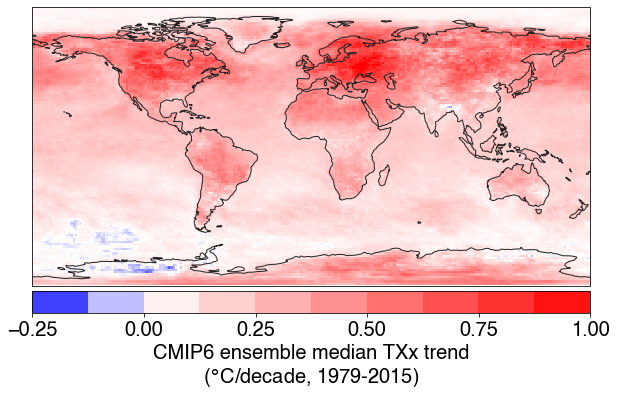

In [41]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

if region == 'us':
    ax.set_extent([-128, -67, 23, 55])
elif region == 'china':
    ax.set_extent([122, 105 , 25, 45])
elif region == 'eu':
    ax.set_extent([39, -5 , 38, 53])

v1 = -.25
v2 = 1.01
vstep = .125
vlabelstep = .25

disp_lat = cmip6_tasmax_max_trend.lat.values.copy()
disp_lon = cmip6_tasmax_max_trend.lon.values.copy()       
disp_data = cmip6_tasmax_max_trend.tasmax_max_trend.median(dim='model').values.copy()

# disp_data, disp_lon = cartopy.util.add_cyclic_point(disp_data, coord=disp_lon)

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')

c = plt.pcolormesh(disp_lon, disp_lat, disp_data, cmap=cmap, norm=midnorm)
# c = plt.contourf(disp_lon, disp_lat, disp_data, cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))

if region == 'global':
    ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')
else:
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('CMIP6 ensemble median TXx trend\n($\degree$C/decade, 1979-2015)', fontsize=20)

# if wxData == 'gldas':
#     plt.savefig('obs-gdd-trend-cpc.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)
# elif wxData == 'era5':
#     plt.savefig('obs-gdd-trend-era5.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

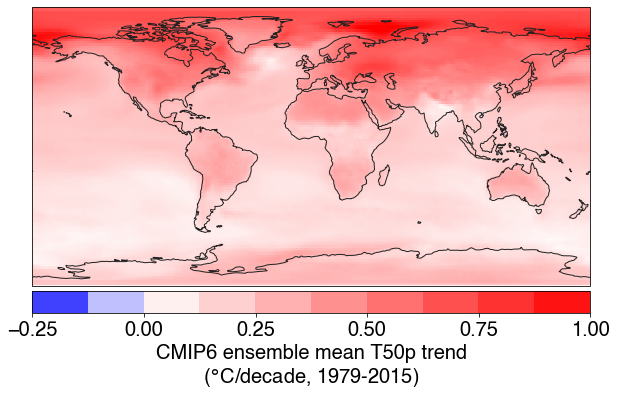

In [42]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

if region == 'us':
    ax.set_extent([-128, -67, 23, 55])
elif region == 'china':
    ax.set_extent([122, 105 , 25, 45])
elif region == 'eu':
    ax.set_extent([39, -5 , 38, 53])

v1 = -.25
v2 = 1.01
vstep = .125
vlabelstep = .25

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')
c = plt.pcolormesh(cmip6_tasmax_mean_trend.lon, cmip6_tasmax_mean_trend.lat, cmip6_tasmax_mean_trend.tasmax_mean_trend.mean(dim='model').values, \
                 cmap=cmap, norm=midnorm)
# c = plt.contourf(cmip6_tasmax_mean_trend.lon, cmip6_tasmax_mean_trend.lat, cmip6_tasmax_mean_trend.tasmax_mean_trend.mean(dim='model').values, cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))


if region == 'global':
    ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')
else:
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')

scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('CMIP6 ensemble mean T50p trend\n($\degree$C/decade, 1979-2015)', fontsize=20)

# if wxData == 'gldas':
#     plt.savefig('obs-gdd-trend-cpc.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)
# elif wxData == 'era5':
#     plt.savefig('obs-gdd-trend-era5.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

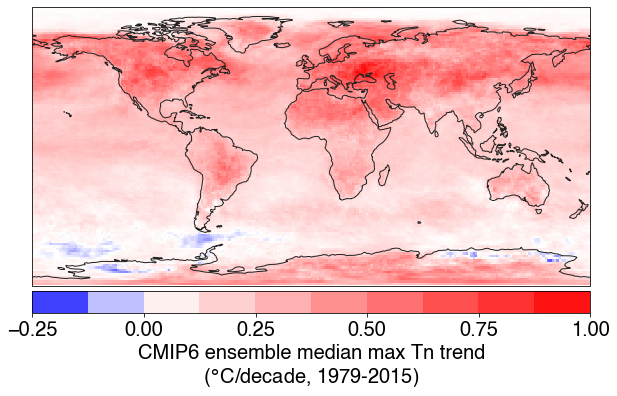

In [43]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

if region == 'us':
    ax.set_extent([-128, -67, 23, 55])
elif region == 'china':
    ax.set_extent([122, 105 , 25, 45])
elif region == 'eu':
    ax.set_extent([39, -5 , 38, 53])

v1 = -.25
v2 = 1.01
vstep = .125
vlabelstep = .25

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')
c = plt.pcolormesh(cmip6_tasmin_max_trend.lon, cmip6_tasmin_max_trend.lat, cmip6_tasmin_max_trend.tasmin_max_trend.median(dim='model').values, \
                 cmap=cmap, norm=midnorm)
# c = plt.contourf(cmip6_tasmin_max_trend.lon, cmip6_tasmin_max_trend.lat, cmip6_tasmin_max_trend.tasmin_max_trend.median(dim='model').values, cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))

if region == 'global':
    ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')
else:
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('CMIP6 ensemble median max Tn trend\n($\degree$C/decade, 1979-2015)', fontsize=20)

# if wxData == 'gldas':
#     plt.savefig('obs-gdd-trend-cpc.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)
# elif wxData == 'era5':
#     plt.savefig('obs-gdd-trend-era5.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

In [44]:
%%time

if os.path.isfile('era5_tasmax_max_regrid_%s.nc'%region):
    print('loading pre-computed era5...')
    era5_tasmax_max_regrid = xr.open_dataset('era5_tasmax_max_regrid_%s.nc'%region)
else:
    era5_tasmax_max = xr.open_dataset('era5_tasmax_max_global.nc')
    era5_tasmax_max = era5_tasmax_max.sel(time=slice('1981', '2014'))

    regridder = xe.Regridder(era5_tasmax_max, regridMesh, 'bilinear', reuse_weights=True)
    regridder.clean_weight_file()
    era5_tasmax_max_regrid = regridder(era5_tasmax_max)
    era5_tasmax_max_regrid.to_netcdf('era5_tasmax_max_regrid_%s.nc'%region)

if os.path.isfile('era5_tasmax_monthly_max_regrid_%s.nc'%region):
    era5_tasmax_monthly_max_regrid = xr.open_dataset('era5_tasmax_monthly_max_regrid_%s.nc'%region)
else:
    era5_tasmax_monthly_max = xr.open_dataset('era5_tasmax_monthly_max_global.nc')
    era5_tasmax_monthly_max = era5_tasmax_monthly_max.sel(time=slice('1981', '2014'))

    regridder = xe.Regridder(era5_tasmax_monthly_max, regridMesh, 'bilinear', reuse_weights=True)
    regridder.clean_weight_file()
    era5_tasmax_monthly_max_regrid = regridder(era5_tasmax_monthly_max)
    era5_tasmax_monthly_max_regrid.to_netcdf('era5_tasmax_monthly_max_regrid_%s.nc'%region)

if os.path.isfile('era5_tasmax_mean_regrid_%s.nc'%region):
    era5_tasmax_mean_regrid = xr.open_dataset('era5_tasmax_mean_regrid_%s.nc'%region)
else:
    era5_tasmax_mean = xr.open_dataset('era5_tasmax_mean_global.nc')
    era5_tasmax_mean = era5_tasmax_mean.sel(time=slice('1981', '2014'))

    regridder = xe.Regridder(era5_tasmax_mean, regridMesh, 'bilinear', reuse_weights=True)
    regridder.clean_weight_file()
    era5_tasmax_mean_regrid = regridder(era5_tasmax_mean)
    era5_tasmax_mean_regrid.to_netcdf('era5_tasmax_mean_regrid_%s.nc'%region)

# if os.path.isfile('era5_tasmin_max_regrid_%s.nc'%region):
#     era5_tasmin_max_regrid = xr.open_dataset('era5_tasmin_max_regrid_%s.nc'%region)
# else:
#     era5_tasmin_max = xr.open_dataset('era5_tasmin_max_global.nc')
#     era5_tasmin_max = era5_tasmin_max.sel(time=slice('1981', '2014'))

#     regridder = xe.Regridder(era5_tasmin_max, regridMesh, 'bilinear', reuse_weights=True)
#     regridder.clean_weight_file()
#     era5_tasmin_max_regrid = regridder(era5_tasmin_max)
#     era5_tasmin_max_regrid.to_netcdf('era5_tasmin_max_regrid_%s.nc'%region)

# if os.path.isfile('era5_tasmin_mean_regrid_%s.nc'%region):
#     era5_tasmin_mean_regrid = xr.open_dataset('era5_tasmin_mean_regrid_%s.nc'%region)
# else:
#     era5_tasmin_mean = xr.open_dataset('era5_tasmin_mean_global.nc')
#     era5_tasmin_mean = era5_tasmin_mean.sel(time=slice('1981', '2014'))

#     regridder = xe.Regridder(era5_tasmin_mean, regridMesh, 'bilinear', reuse_weights=True)
#     regridder.clean_weight_file()
#     era5_tasmin_mean_regrid = regridder(era5_tasmin_mean)
#     era5_tasmin_mean_regrid.to_netcdf('era5_tasmin_mean_regrid_%s.nc'%region)

loading pre-computed era5...
CPU times: user 16.2 ms, sys: 125 µs, total: 16.3 ms
Wall time: 15.4 ms


In [45]:
era5_tasmax_monthly_max_regrid

<xarray.Dataset>
Dimensions:             (lat: 120, lon: 240, time: 408)
Coordinates:
  * time                (time) datetime64[ns] 1981-01-31 ... 2014-12-31
  * lon                 (lon) float64 0.0 1.5 3.0 4.5 ... 355.5 357.0 358.5
  * lat                 (lat) float64 -90.0 -88.5 -87.0 -85.5 ... 85.5 87.0 88.5
Data variables:
    tasmax_monthly_max  (time, lat, lon) float64 ...
Attributes:
    regrid_method:  bilinear

In [46]:
%%time

if os.path.isfile('era5_tasmax_max_trend_%s.nc'%region):
    era5_tasmax_max_trend = xr.open_dataset('era5_tasmax_max_trend_%s.nc'%region)
    era5_tasmax_monthly_max_trend = xr.open_dataset('era5_tasmax_monthly_max_trend_%s.nc'%region)
    era5_tasmax_mean_trend = xr.open_dataset('era5_tasmax_mean_trend_%s.nc'%region)
else:
    # calc era5 txx and t50p trends
    era5_tasmax_max_trend = xr.Dataset()
    era5_tasmax_monthly_max_trend = xr.Dataset()
    era5_tasmax_mean_trend = xr.Dataset()

    era5_tasmin_max_trend = xr.Dataset()
    era5_tasmin_mean_trend = xr.Dataset()

    print('calc era5 txx and t50p trends')
    tmp_tasmax_max_trend = np.full([era5_tasmax_max_regrid.lat.values.shape[0], era5_tasmax_max_regrid.lon.values.shape[0]], np.nan)
    tmp_tasmax_monthly_max_trend = np.full([12, era5_tasmax_max_regrid.lat.values.shape[0], era5_tasmax_max_regrid.lon.values.shape[0]], np.nan)
    tmp_tasmax_mean_trend = np.full([era5_tasmax_mean_regrid.lat.values.shape[0], era5_tasmax_mean_regrid.lon.values.shape[0]], np.nan)

    # tmp_tasmin_max_trend = np.full([era5_tasmin_max_regrid.lat.values.shape[0], era5_tasmin_max_regrid.lon.values.shape[0]], np.nan)
    # tmp_tasmin_mean_trend = np.full([era5_tasmin_mean_regrid.lat.values.shape[0], era5_tasmin_mean_regrid.lon.values.shape[0]], np.nan)

    monthly_groups = era5_tasmax_monthly_max_regrid.groupby('time.month').groups

    for xlat in range(tmp_tasmax_max_trend.shape[0]):
        for ylon in range(tmp_tasmax_max_trend.shape[1]):
            cur_tasmax_max = era5_tasmax_max_regrid.tasmax_max.values[:, xlat, ylon]
            X = sm.add_constant(range(1981, 2014+1))
            mdl = sm.OLS(cur_tasmax_max, X).fit()
            tmp_tasmax_max_trend[xlat, ylon] = mdl.params[1]*10

            cur_tasmax_mean = era5_tasmax_mean_regrid.tasmax_mean.values[:, xlat, ylon]
            X = sm.add_constant(range(1981, 2014+1))
            mdl = sm.OLS(cur_tasmax_mean, X).fit()
            tmp_tasmax_mean_trend[xlat, ylon] = mdl.params[1]*10

    #         cur_tasmin_max = era5_tasmin_max_regrid.tasmin_max.values[:, xlat, ylon]
    #         X = sm.add_constant(range(1981, 2014+1))
    #         mdl = sm.OLS(cur_tasmin_max, X).fit()
    #         tmp_tasmin_max_trend[xlat, ylon] = mdl.params[1]*10

    #         cur_tasmin_mean = era5_tasmin_mean_regrid.tasmin_mean.values[:, xlat, ylon]
    #         X = sm.add_constant(range(1981, 2014+1))
    #         mdl = sm.OLS(cur_tasmin_mean, X).fit()
    #         tmp_tasmin_mean_trend[xlat, ylon] = mdl.params[1]*10

            for month in range(1, 13):
                curMonthlyTx = era5_tasmax_monthly_max_regrid['tasmax_monthly_max'].values[monthly_groups[month], xlat, ylon]
                X = sm.add_constant(range(1981, 2014+1))
                mdl = sm.OLS(curMonthlyTx, X).fit()
                tmp_tasmax_monthly_max_trend[month-1, xlat, ylon] = mdl.params[1]*10

    era5_tasmax_max_trend['tasmax_max_trend'] = xr.DataArray(data   = tmp_tasmax_max_trend, 
                      dims   = ['lat', 'lon'],
                      coords = {'lat':era5_tasmax_max_regrid.lat, 'lon':era5_tasmax_max_regrid.lon},
                      attrs  = {'units'     : 'C'
                        })
    era5_tasmax_max_trend.to_netcdf('era5_tasmax_max_trend_%s.nc'%region)

    era5_tasmax_monthly_max_trend['tasmax_monthly_max_trend'] = xr.DataArray(data   = tmp_tasmax_monthly_max_trend, 
                      dims   = ['month', 'lat', 'lon'],
                      coords = {'month':np.arange(1,13), 'lat':era5_tasmax_monthly_max_regrid.lat, 'lon':era5_tasmax_monthly_max_regrid.lon},
                      attrs  = {'units'     : 'C'
                        })
    era5_tasmax_monthly_max_trend.to_netcdf('era5_tasmax_monthly_max_trend_%s.nc'%region)

    era5_tasmax_mean_trend['tasmax_mean_trend'] = xr.DataArray(data   = tmp_tasmax_mean_trend, 
                      dims   = ['lat', 'lon'],
                      coords = {'lat':era5_tasmax_mean_regrid.lat, 'lon':era5_tasmax_mean_regrid.lon},
                      attrs  = {'units'     : 'C'
                        })
    era5_tasmax_mean_trend.to_netcdf('era5_tasmax_mean_trend_%s.nc'%region)

    # era5_tasmin_max_trend['tasmin_max_trend'] = xr.DataArray(data   = tmp_tasmin_max_trend, 
    #                   dims   = ['lat', 'lon'],
    #                   coords = {'lat':era5_tasmin_max_regrid.lat, 'lon':era5_tasmin_max_regrid.lon},
    #                   attrs  = {'units'     : 'C'
    #                     })

    # era5_tasmin_mean_trend['tasmin_mean_trend'] = xr.DataArray(data   = tmp_tasmin_mean_trend, 
    #                   dims   = ['lat', 'lon'],
    #                   coords = {'lat':era5_tasmin_mean_regrid.lat, 'lon':era5_tasmin_mean_regrid.lon},
    #                   attrs  = {'units'     : 'C'
    #                     })


CPU times: user 7.35 ms, sys: 194 µs, total: 7.54 ms
Wall time: 7.17 ms


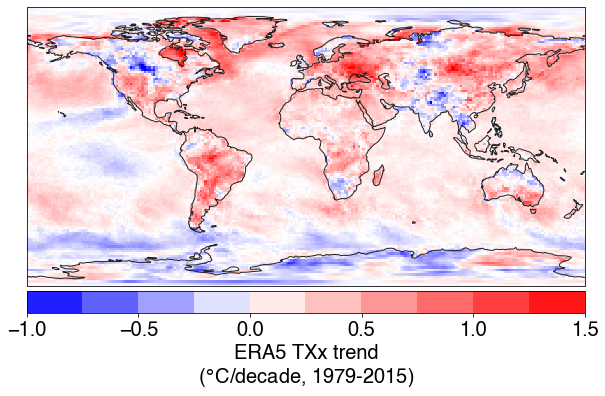

In [47]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

if region == 'us':
    ax.set_extent([-128, -67, 23, 55])
elif region == 'china':
    ax.set_extent([122, 105 , 25, 45])
elif region == 'eu':
    ax.set_extent([39, -5 , 38, 53])

v1 = -1
v2 = 1.51
vstep = .25
vlabelstep = .5

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')

c = plt.pcolormesh(era5_tasmax_max_trend.lon, era5_tasmax_max_trend.lat, era5_tasmax_max_trend.tasmax_max_trend.values, cmap=cmap, norm=midnorm)
# c = plt.contourf(era5_tasmax_max_trend.lon, era5_tasmax_max_trend.lat, era5_tasmax_max_trend.tasmax_max_trend.values, cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))

if region == 'global':
    ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')
else:
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('ERA5 TXx trend\n($\degree$C/decade, 1979-2015)', fontsize=20)

# if wxData == 'gldas':
#     plt.savefig('obs-gdd-trend-cpc.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)
# elif wxData == 'era5':
#     plt.savefig('obs-gdd-trend-era5.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

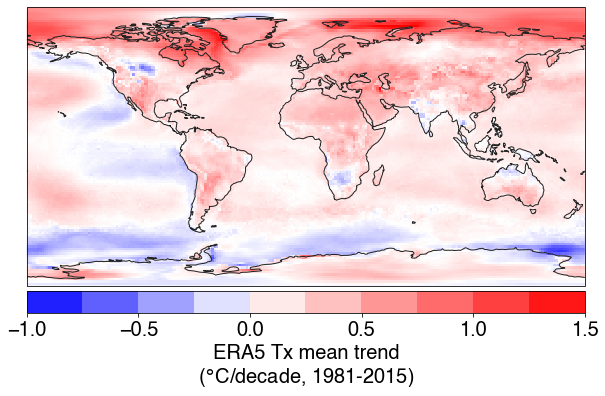

In [48]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

if region == 'us':
    ax.set_extent([-128, -67, 23, 55])
elif region == 'china':
    ax.set_extent([122, 105 , 25, 45])
elif region == 'eu':
    ax.set_extent([39, -5 , 38, 53])

v1 = -1
v2 = 1.51
vstep = .25
vlabelstep = .5

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')
c = plt.pcolormesh(era5_tasmax_mean_trend.lon, era5_tasmax_mean_trend.lat, era5_tasmax_mean_trend.tasmax_mean_trend.values, cmap=cmap, norm=midnorm)
# c = plt.contourf(era5_tasmax_mean_trend.lon, era5_tasmax_mean_trend.lat, era5_tasmax_mean_trend.tasmax_mean_trend.values, cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))

if region == 'global':
    ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')
else:
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('ERA5 Tx mean trend\n($\degree$C/decade, 1981-2015)', fontsize=20)

# if wxData == 'gldas':
#     plt.savefig('obs-gdd-trend-cpc.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)
# elif wxData == 'era5':
#     plt.savefig('obs-gdd-trend-era5.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

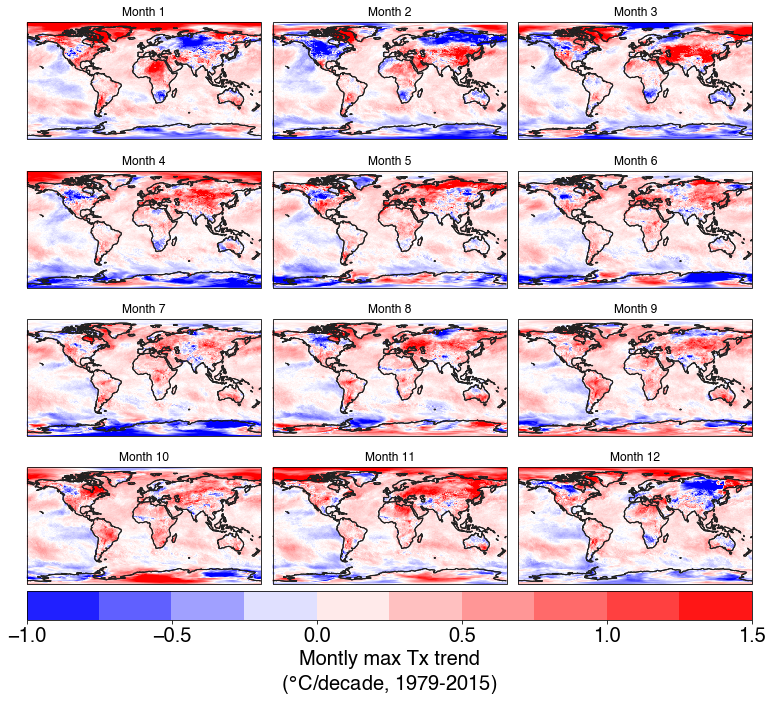

In [49]:
fig = plt.figure(figsize=(13,13))
gs = fig.add_gridspec(4,3)
gs.update(wspace=0.05, hspace=0)

m = 0
for row in range(4):
    for col in range(3):
        ax = fig.add_subplot(gs[row, col], projection=ccrs.PlateCarree())
#         ax.set_extent([-140, 155, -55, 70], crs=ccrs.PlateCarree())
        ax.coastlines()

#         data, plot_lon_vals = cartopy.util.add_cyclic_point(np.nanmean(lh_grid_hist[:,:,:,m], axis=2) - \
#                                                     np.nanmean(lh_grid_hist_nocrop[:,:,:,m], axis=2),\
#                                                     coord=lon_vals)
        
        v1 = -1
        v2 = 1.51
        vstep = .25
        vlabelstep = .5

        midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
        cmap = plt.cm.get_cmap('bwr')
        c = plt.pcolormesh(era5_tasmax_monthly_max_trend.lon, era5_tasmax_monthly_max_trend.lat, era5_tasmax_monthly_max_trend.tasmax_monthly_max_trend.values[m,:,:], cmap=cmap, norm=midnorm)
        # c = plt.contourf(era5_tasmax_mean_trend.lon, era5_tasmax_mean_trend.lat, era5_tasmax_mean_trend.tasmax_mean_trend.values, cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))

        if region == 'global' or region == 'eu':
            ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')
        else:
            ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')

        scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
        scmap.set_array([])
        
        ax.set_title('Month %d'%(m+1))
#         ax.set_aspect('auto')
        m += 1

# cax, kw = mpl.colorbar.make_axes()
# cbar = fig.colorbar(sm, ax=[ax1, ax2], orientation="horizontal", ticks = np.arange(6), pad=0.05,, extend="max")

cb = fig.colorbar(scmap, ax=plt.gcf().get_axes(), ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal', use_gridspec=True,
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Montly max Tx trend\n($\degree$C/decade, 1979-2015)', fontsize=20)

NameError: name 'era5_tasmin_max_trend' is not defined

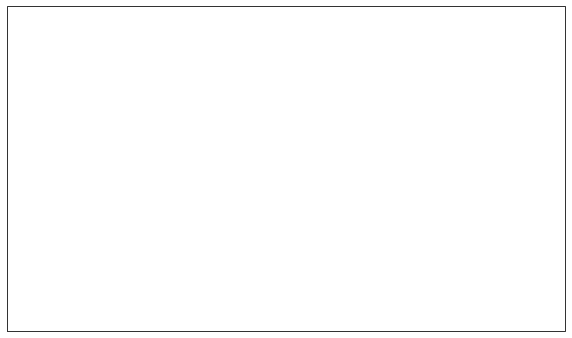

In [50]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-128, -67, 23, 55])

v1 = -1
v2 = 1.51
vstep = .25
vlabelstep = .5

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')
c = plt.pcolormesh(era5_tasmin_max_trend.lon, era5_tasmin_max_trend.lat, era5_tasmin_max_trend.tasmin_max_trend.values, cmap=cmap, norm=midnorm)
# c = plt.contourf(era5_tasmin_max_trend.lon, era5_tasmin_max_trend.lat, era5_tasmin_max_trend.tasmin_max_trend.values, cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('ERA5 max Tn trend\n($\degree$C/decade, 1979-2015)', fontsize=20)

# if wxData == 'gldas':
#     plt.savefig('obs-gdd-trend-cpc.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)
# elif wxData == 'era5':
#     plt.savefig('obs-gdd-trend-era5.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

In [ ]:

# calculate trend bias between cmip6 and era5

# TASMAX ANNUAL MAX
print('tasmax annual max')
cmip6_era5_tasmax_max_trend_bias_sig = np.full(era5_tasmax_max_trend.tasmax_max_trend.shape, np.nan)
cmip6_era5_tasmax_max_trend_bias = np.full([len(cmip6_models), era5_tasmax_max_trend.tasmax_max_trend.shape[0], era5_tasmax_max_trend.tasmax_max_trend.shape[1]], np.nan)

for m, model in enumerate(cmip6_models):
    cmip6_era5_tasmax_max_trend_bias[m,:,:] = cmip6_tasmax_max_trend.tasmax_max_trend.values[m,:,:] - era5_tasmax_max_trend.tasmax_max_trend.values

for xlat in range(cmip6_era5_tasmax_max_trend_bias_sig.shape[0]):
    for ylon in range(cmip6_era5_tasmax_max_trend_bias_sig.shape[1]):
        t, p = scipy.stats.ttest_1samp(cmip6_era5_tasmax_max_trend_bias[:, xlat, ylon], 0)
        cmip6_era5_tasmax_max_trend_bias_sig[xlat, ylon] = p

# TASMAX MONTHLY MAX
print('tasmax monthly max')
cmip6_era5_tasmax_monthly_max_trend_bias_sig = np.full([12, era5_tasmax_monthly_max_trend.tasmax_monthly_max_trend.shape[1], era5_tasmax_monthly_max_trend.tasmax_monthly_max_trend.shape[2]], np.nan)
cmip6_era5_tasmax_monthly_max_trend_bias = np.full([12, len(cmip6_models), era5_tasmax_monthly_max_trend.tasmax_monthly_max_trend.shape[1], era5_tasmax_monthly_max_trend.tasmax_monthly_max_trend.shape[2]], np.nan)

for m, model in enumerate(cmip6_models):
    for month in range(12):
        cmip6_era5_tasmax_monthly_max_trend_bias[month,m,:,:] = cmip6_tasmax_monthly_max_trend.tasmax_monthly_max_trend.values[m,month,:,:] - era5_tasmax_monthly_max_trend.tasmax_monthly_max_trend.values[month,:,:]

for month in range(12):
    print('month %d'%month)
    for xlat in range(cmip6_era5_tasmax_monthly_max_trend_bias_sig.shape[1]):
        for ylon in range(cmip6_era5_tasmax_monthly_max_trend_bias_sig.shape[2]):
            t, p = scipy.stats.ttest_1samp(cmip6_era5_tasmax_monthly_max_trend_bias[month,:, xlat, ylon], 0)
            cmip6_era5_tasmax_monthly_max_trend_bias_sig[month,xlat, ylon] = p

# TASMAX ANNUAL MEAN
print('tasmax annual mean')
cmip6_era5_tasmax_mean_trend_bias_sig = np.full(era5_tasmax_mean_trend.tasmax_mean_trend.shape, np.nan)
cmip6_era5_tasmax_mean_trend_bias = np.full([len(cmip6_models), era5_tasmax_mean_trend.tasmax_mean_trend.shape[0], era5_tasmax_mean_trend.tasmax_mean_trend.shape[1]], np.nan)

for m, model in enumerate(cmip6_models):
    cmip6_era5_tasmax_mean_trend_bias[m,:,:] = cmip6_tasmax_mean_trend.tasmax_mean_trend.values[m,:,:] - era5_tasmax_mean_trend.tasmax_mean_trend.values

for xlat in range(cmip6_era5_tasmax_mean_trend_bias_sig.shape[0]):
    for ylon in range(cmip6_era5_tasmax_mean_trend_bias_sig.shape[1]):
        t, p = scipy.stats.ttest_1samp(cmip6_era5_tasmax_mean_trend_bias[:, xlat, ylon], 0)
        cmip6_era5_tasmax_mean_trend_bias_sig[xlat, ylon] = p

In [ ]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

if region == 'us':
    ax.set_extent([-128, -67, 23, 55])
elif region == 'china':
    ax.set_extent([122, 105 , 25, 45])
elif region == 'eu':
    ax.set_extent([39, -5 , 38, 53])

v1 = -1
v2 = 1.51
vstep = .25
vlabelstep = .5

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')

c = plt.pcolormesh(era5_tasmax_max_trend.lon, era5_tasmax_max_trend.lat, np.nanmedian(cmip6_era5_tasmax_max_trend_bias, axis=0), 
                 cmap=cmap, norm=midnorm)

# c = plt.contourf(era5_tasmax_max_trend.lon, era5_tasmax_max_trend.lat, np.nanmedian(cmip6_era5_tasmax_max_trend_bias, axis=0), cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))
# plt.contourf(era5_tasmax_max_trend.lon, era5_tasmax_max_trend.lat, cmip6_era5_tasmax_max_trend_bias_sig, levels=[0, 0.05], colors='none', hatches=['///', ''])

if region == 'global':
    ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')
else:
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Bias in TXx trend (CMIP6-ERA5)\n($\degree$C/decade, 1981-2015)', fontsize=20)

In [ ]:
fig = plt.figure(figsize=(13,13))
gs = fig.add_gridspec(4,3)
gs.update(wspace=0.05, hspace=0)

m = 0
for row in range(4):
    for col in range(3):
        ax = fig.add_subplot(gs[row, col], projection=ccrs.PlateCarree())
#         ax.set_extent([-140, 155, -55, 70], crs=ccrs.PlateCarree())
        ax.coastlines()
    
        v1 = -1
        v2 = 1.51
        vstep = .25
        vlabelstep = .5

        midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
        cmap = plt.cm.get_cmap('bwr')
        c = plt.pcolormesh(era5_tasmax_monthly_max_trend.lon, era5_tasmax_monthly_max_trend.lat, np.nanmean(cmip6_era5_tasmax_monthly_max_trend_bias, axis=1)[m,:,:], cmap=cmap, norm=midnorm)
        # c = plt.contourf(era5_tasmax_mean_trend.lon, era5_tasmax_mean_trend.lat, era5_tasmax_mean_trend.tasmax_mean_trend.values, cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))

        if region == 'global' or region == 'eu':
            ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')
        else:
            ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')

        scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
        scmap.set_array([])
        
        ax.set_title('Month %d'%(m+1))
#         ax.set_aspect('auto')
        m += 1

# cax, kw = mpl.colorbar.make_axes()
# cbar = fig.colorbar(sm, ax=[ax1, ax2], orientation="horizontal", ticks = np.arange(6), pad=0.05,, extend="max")

cb = fig.colorbar(scmap, ax=plt.gcf().get_axes(), ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal', use_gridspec=True,
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Bias in monthly max Tx trend\n(CMIP6-ERA5, $\degree$C/decade, 1979-2015)', fontsize=20)

In [ ]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

if region == 'us':
    ax.set_extent([-128, -67, 23, 55])
elif region == 'china':
    ax.set_extent([122, 105 , 25, 45])
elif region == 'eu':
    ax.set_extent([39, -5 , 38, 53])

v1 = -1
v2 = 1.51
vstep = .25
vlabelstep = .5

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')

c = plt.pcolormesh(era5_tasmax_mean_trend.lon, era5_tasmax_mean_trend.lat, np.nanmedian(cmip6_era5_tasmax_mean_trend_bias, axis=0), cmap=cmap, norm=midnorm)
# c = plt.contourf(era5_tasmax_mean_trend.lon, era5_tasmax_mean_trend.lat, np.nanmedian(cmip6_era5_tasmax_mean_trend_bias, axis=0), cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))

# plt.contourf(era5_tasmax_mean_trend.lon, era5_tasmax_mean_trend.lat, cmip6_era5_tasmax_mean_trend_bias_sig, levels=[0, 0.05], colors='none', hatches=['/', ''])

if region == 'global':
    ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')
else:
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Bias in Tx mean trend (CMIP6-ERA5)\n($\degree$C/decade, 1981-2015)', fontsize=20)

In [26]:
# load pre-calculated bias by year

monthly_groups = cmip6_tasmax_monthly_max.groupby('time.month').groups

yearly_tasmax_max_bias = np.full([len(cmip6_models), era5_tasmax_max_regrid.time.values.shape[0], \
                                  era5_tasmax_max_regrid.lat.values.shape[0], \
                                  era5_tasmax_max_regrid.lon.values.shape[0]], np.nan)
yearly_tasmax_monthly_max_bias = np.full([len(cmip6_models), 12, len(monthly_groups[1]), \
                                  cmip6_tasmax_monthly_max.lat.values.shape[0], \
                                  cmip6_tasmax_monthly_max.lon.values.shape[0]], np.nan)
yearly_tasmax_mean_bias = np.full([len(cmip6_models), era5_tasmax_mean_regrid.time.values.shape[0], \
                                   era5_tasmax_mean_regrid.lat.values.shape[0], \
                                   era5_tasmax_mean_regrid.lon.values.shape[0]], np.nan)

for m, model in enumerate(cmip6_models):
    print('loading yearly bias for %s'%model)
    with open('cmip6_output/bias/yearly-cmip6-era5-tasmax-max-bias-%s-%s.dat'%(region, model), 'rb') as f:
        yearly_tasmax_max_bias[m, :, :, :] = pickle.load(f)
    with open('cmip6_output/bias/yearly-cmip6-era5-tasmax-monthly-max-bias-%s-%s.dat'%(region, model), 'rb') as f:
        yearly_tasmax_monthly_max_bias[m, :, :, :, :] = pickle.load(f)
    with open('cmip6_output/bias/yearly-cmip6-era5-tasmax-mean-bias-%s-%s.dat'%(region, model), 'rb') as f:
        yearly_tasmax_mean_bias[m, :, :, :] = pickle.load(f)


loading yearly bias for access-cm2
loading yearly bias for access-esm1-5
loading yearly bias for awi-cm-1-1-mr
loading yearly bias for bcc-csm2-mr


FileNotFoundError: [Errno 2] No such file or directory: 'cmip6_output/bias/yearly-cmip6-era5-tasmax-max-bias-global-bcc-csm2-mr.dat'

In [ ]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

if region == 'us':
    ax.set_extent([-128, -67, 23, 55])
elif region == 'china':
    ax.set_extent([122, 105 , 25, 45])
elif region == 'eu':
    ax.set_extent([39, -5 , 38, 53])


v1 = -10
v2 = 10.01
vstep = 1
vlabelstep = 2

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')

c = plt.pcolormesh(era5_tasmax_max_trend.lon, era5_tasmax_max_trend.lat, \
                 np.nanmedian(np.nanmean(yearly_tasmax_max_bias, axis=1), axis=0), \
                 cmap=cmap, norm=midnorm)
# c = plt.contourf(era5_tasmax_max_trend.lon, era5_tasmax_max_trend.lat, \
#                  np.nanmedian(np.nanmean(yearly_tasmax_max_bias, axis=1), axis=0), \
#                  cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))

if region == 'global':
    ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')
else:
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Mean TXx bias (CMIP6-ERA5)\n($\degree$C, 1981-2015)', fontsize=20)

In [ ]:
fig = plt.figure(figsize=(13,13))
gs = fig.add_gridspec(4,3)
gs.update(wspace=0.05, hspace=0)

m = 0
for row in range(4):
    for col in range(3):
        ax = fig.add_subplot(gs[row, col], projection=ccrs.PlateCarree())
#         ax.set_extent([-140, 155, -55, 70], crs=ccrs.PlateCarree())
        ax.coastlines()
    
        v1 = -10
        v2 = 10.1
        vstep = 1
        vlabelstep = 2

        midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
        cmap = plt.cm.get_cmap('bwr')
        c = plt.pcolormesh(era5_tasmax_monthly_max_trend.lon, era5_tasmax_monthly_max_trend.lat, \
                           np.nanmean(np.nanmean(yearly_tasmax_monthly_max_bias[:,m,:,:,:], axis=0), axis=0), \
                           cmap=cmap, norm=midnorm)
        # c = plt.contourf(era5_tasmax_mean_trend.lon, era5_tasmax_mean_trend.lat, era5_tasmax_mean_trend.tasmax_mean_trend.values, cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))

        if region == 'global':
            ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')
        else:
            ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')

        scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
        scmap.set_array([])
        
        ax.set_title('Month %d'%(m+1))
#         ax.set_aspect('auto')
        m += 1

# cax, kw = mpl.colorbar.make_axes()
# cbar = fig.colorbar(sm, ax=[ax1, ax2], orientation="horizontal", ticks = np.arange(6), pad=0.05,, extend="max")

cb = fig.colorbar(scmap, ax=plt.gcf().get_axes(), ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal', use_gridspec=True,
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Mean monthly max Tx bias\n(CMIP6-ERA5, $\degree$C/decade, 1979-2015)', fontsize=20)

In [ ]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

if region == 'us':
    ax.set_extent([-128, -67, 23, 55])
elif region == 'china':
    ax.set_extent([122, 105 , 25, 45])
elif region == 'eu':
    ax.set_extent([39, -5 , 38, 53])


v1 = -10
v2 = 10.01
vstep = 1
vlabelstep = 2

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')

c = plt.pcolormesh(era5_tasmax_mean_trend.lon, era5_tasmax_mean_trend.lat, \
                 np.nanmedian(np.nanmean(yearly_tasmax_mean_bias, axis=1), axis=0), \
                 cmap=cmap, norm=midnorm)

# c = plt.contourf(era5_tasmax_mean_trend.lon, era5_tasmax_mean_trend.lat, \
#                  np.nanmedian(np.nanmean(yearly_tasmax_mean_bias, axis=1), axis=0), \
#                  cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))
# plt.contourf(era5_txx_trend.lon, era5_txx_trend.lat, yearly_txx_bias_trend_sig, levels=[0, 0.1], colors='none', hatches=['/', ''])

if region == 'global':
    ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')
else:
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')

scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Mean Tx bias (CMIP6-ERA5)\n($\degree$C, 1981-2015)', fontsize=20)

In [ ]:
recalc = False
if os.path.isfile('yearly-cmip6-era5-tasmax-bias-trend-%s.dat'%region) and not recalc:
    print('loading precomputed bias trend...')
    with open('yearly-cmip6-era5-tasmax-bias-trend-%s.dat'%region, 'rb') as f:
        f = pickle.load(f)
        yearly_tasmax_max_bias_trend = f['yearly_tasmax_max_bias_trend']
        yearly_tasmax_max_bias_trend_sig = f['yearly_tasmax_max_bias_trend_sig']
        
        yearly_tasmax_monthly_max_bias_trend = f['yearly_tasmax_monthly_max_bias_trend']
        yearly_tasmax_monthly_max_bias_trend_sig = f['yearly_tasmax_monthly_max_bias_trend_sig']
        
        yearly_tasmax_mean_bias_trend = f['yearly_tasmax_mean_bias_trend']
        yearly_tasmax_mean_bias_trend_sig = f['yearly_tasmax_mean_bias_trend_sig']

else:
    yearly_tasmax_max_bias_trend = np.full([len(cmip6_models), yearly_tasmax_max_bias.shape[2], yearly_tasmax_max_bias.shape[3]], np.nan)
    yearly_tasmax_max_bias_trend_sig = np.full([len(cmip6_models), yearly_tasmax_max_bias.shape[2], yearly_tasmax_max_bias.shape[3]], np.nan)
    
    yearly_tasmax_monthly_max_bias_trend = np.full([len(cmip6_models), 12, yearly_tasmax_max_bias.shape[2], yearly_tasmax_max_bias.shape[3]], np.nan)
    yearly_tasmax_monthly_max_bias_trend_sig = np.full([len(cmip6_models), 12, yearly_tasmax_max_bias.shape[2], yearly_tasmax_max_bias.shape[3]], np.nan)

    yearly_tasmax_mean_bias_trend = np.full([len(cmip6_models), yearly_tasmax_mean_bias.shape[2], yearly_tasmax_mean_bias.shape[3]], np.nan)
    yearly_tasmax_mean_bias_trend_sig = np.full([len(cmip6_models), yearly_tasmax_mean_bias.shape[2], yearly_tasmax_mean_bias.shape[3]], np.nan)

    for m in range(len(cmip6_models_tasmax)):
        print('processing %s...'%cmip6_models_tasmax[m])
        for xlat in range(yearly_tasmax_max_bias_trend.shape[1]):
            for ylon in range(yearly_tasmax_max_bias_trend.shape[2]):
                curBias = np.squeeze(yearly_tasmax_max_bias[m, :, xlat, ylon])
                X = sm.add_constant(range(1981, 2015))
                mdl = sm.RLM(curBias, X).fit()
                yearly_tasmax_max_bias_trend[m, xlat, ylon] = mdl.params[1]*10
                yearly_tasmax_max_bias_trend_sig[m, xlat, ylon] = mdl.pvalues[1]

                curBias = np.squeeze(yearly_tasmax_mean_bias[m, :, xlat, ylon])
                X = sm.add_constant(range(1981, 2015))
                mdl = sm.RLM(curBias, X).fit()
                yearly_tasmax_mean_bias_trend[m, xlat, ylon] = mdl.params[1]*10
                yearly_tasmax_mean_bias_trend_sig[m, xlat, ylon] = mdl.pvalues[1]
                
                for month in range(12):
                    curBias = np.squeeze(yearly_tasmax_monthly_max_bias[m, month, :, xlat, ylon])
                    X = sm.add_constant(range(1981, 2015))
                    mdl = sm.RLM(curBias, X).fit()
                    yearly_tasmax_monthly_max_bias_trend[m, month, xlat, ylon] = mdl.params[1]*10
                    yearly_tasmax_monthly_max_bias_trend_sig[m, month, xlat, ylon] = mdl.pvalues[1]

    with open('yearly-cmip6-era5-tasmax-bias-trend-%s.dat'%region, 'wb') as f:
        pickle.dump({'yearly_tasmax_max_bias_trend': yearly_tasmax_max_bias_trend,
                     'yearly_tasmax_max_bias_trend_sig':yearly_tasmax_max_bias_trend_sig,
                     'yearly_tasmax_monthly_max_bias_trend': yearly_tasmax_monthly_max_bias_trend,
                     'yearly_tasmax_monthly_max_bias_trend_sig':yearly_tasmax_monthly_max_bias_trend_sig,
                     'yearly_tasmax_mean_bias_trend':yearly_tasmax_mean_bias_trend,
                     'yearly_tasmax_mean_bias_trend_sig':yearly_tasmax_mean_bias_trend_sig}, f)

In [ ]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

if region == 'us':
    ax.set_extent([-128, -67, 23, 55])
elif region == 'china':
    ax.set_extent([122, 105 , 25, 45])
elif region == 'eu':
    ax.set_extent([39, -5 , 38, 53])


v1 = -1
v2 = 1.51
vstep = .25
vlabelstep = .5

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')

c = plt.pcolormesh(era5_tasmax_max_trend.lon, era5_tasmax_max_trend.lat, \
                 np.nanmedian(yearly_tasmax_max_bias_trend, axis=0), cmap=cmap, norm=midnorm)
# c = plt.contourf(era5_tasmax_max_trend.lon, era5_tasmax_max_trend.lat, \
#                  np.nanmedian(yearly_tasmax_max_bias_trend, axis=0), cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))

plt.contourf(era5_tasmax_max_trend.lon, era5_tasmax_max_trend.lat, \
             np.nanmedian(yearly_tasmax_max_bias_trend_sig, axis=0), levels=[0, 0.1], colors='none', hatches=['/', ''])

if region == 'global':
    ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')
else:
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')

scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Trend in TXx bias (CMIP6-ERA5)\n($\degree$C/decade, 1981-2015)', fontsize=20)

In [ ]:
yearly_tasmax_max_bias_trend.shape

In [ ]:
fig = plt.figure(figsize=(13,13))
gs = fig.add_gridspec(4,3)
gs.update(wspace=0.05, hspace=0)

m = 0
for row in range(4):
    for col in range(3):
        ax = fig.add_subplot(gs[row, col], projection=ccrs.PlateCarree())
#         ax.set_extent([-140, 155, -55, 70], crs=ccrs.PlateCarree())
        ax.coastlines()
    
        v1 = -1
        v2 = 1.51
        vstep = .25
        vlabelstep = .5

        midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
        cmap = plt.cm.get_cmap('bwr')
        c = plt.pcolormesh(era5_tasmax_monthly_max_trend.lon, era5_tasmax_monthly_max_trend.lat, \
                           np.nanmean(yearly_tasmax_monthly_max_bias_trend[:,m,:,:], axis=0), \
                           cmap=cmap, norm=midnorm)
        # c = plt.contourf(era5_tasmax_mean_trend.lon, era5_tasmax_mean_trend.lat, era5_tasmax_mean_trend.tasmax_mean_trend.values, cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))

        if region == 'global':
            ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')
        else:
            ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')

        scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
        scmap.set_array([])
        
        ax.set_title('Month %d'%(m+1))
#         ax.set_aspect('auto')
        m += 1

# cax, kw = mpl.colorbar.make_axes()
# cbar = fig.colorbar(sm, ax=[ax1, ax2], orientation="horizontal", ticks = np.arange(6), pad=0.05,, extend="max")

cb = fig.colorbar(scmap, ax=plt.gcf().get_axes(), ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal', use_gridspec=True,
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Trend in monthly max Tx bias\n(CMIP6-ERA5, $\degree$C/decade, 1979-2015)', fontsize=20)

In [ ]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

if region == 'us':
    ax.set_extent([-128, -67, 23, 55])
elif region == 'china':
    ax.set_extent([122, 105 , 25, 45])
elif region == 'eu':
    ax.set_extent([39, -5 , 38, 53])


v1 = -1
v2 = 1.51
vstep = .25
vlabelstep = .5

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')

c = plt.pcolormesh(era5_tasmax_mean_trend.lon, era5_tasmax_mean_trend.lat, \
                 np.nanmedian(yearly_tasmax_mean_bias_trend, axis=0), cmap=cmap, norm=midnorm)
# c = plt.contourf(era5_tasmax_mean_trend.lon, era5_tasmax_mean_trend.lat, \
#                  np.nanmedian(yearly_tasmax_mean_bias_trend, axis=0), cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))

plt.contourf(era5_tasmax_mean_trend.lon, era5_tasmax_mean_trend.lat, \
             np.nanmedian(yearly_tasmax_mean_bias_trend_sig, axis=0), levels=[0, 0.1], colors='none', hatches=['/', ''])

if region == 'global':
    ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')
else:
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')

scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Trend in mean Tx bias (CMIP6-ERA5)\n($\degree$C/decade, 1981-2015)', fontsize=20)

In [663]:
regridMesh

<xarray.Dataset>
Dimensions:  (lat: 120, lon: 240)
Coordinates:
  * lat      (lat) float64 -90.0 -88.5 -87.0 -85.5 -84.0 ... 84.0 85.5 87.0 88.5
  * lon      (lon) float64 0.0 1.5 3.0 4.5 6.0 ... 352.5 354.0 355.5 357.0 358.5
Data variables:
    *empty*

In [664]:
# load cropped area data

maize_ha_regrid_15 = np.full([2, regridMesh['lat'].size, regridMesh['lon'].size], np.nan)
soy_ha_regrid_15 = np.full([2, regridMesh['lat'].size, regridMesh['lon'].size], np.nan)
wheat_ha_regrid_15 = np.full([2, regridMesh['lat'].size, regridMesh['lon'].size], np.nan)
rice_ha_regrid_15 = np.full([2, regridMesh['lat'].size, regridMesh['lon'].size], np.nan)

for c, ca_year in enumerate([1995, 2005]):

    print('processing %d...'%ca_year)
    
    with open('cropped_area/maize_hw_%d_regrid.dat'%ca_year, 'rb') as f:
        maize_ha_regrid_era5 = pickle.load(f)

    with open('cropped_area/soy_hw_%d_regrid.dat'%ca_year, 'rb') as f:
        soy_ha_regrid_era5 = pickle.load(f)

    with open('cropped_area/wheat_hw_%d_regrid.dat'%ca_year, 'rb') as f:
        wheat_ha_regrid_era5 = pickle.load(f)

    with open('cropped_area/rice_hw_%d_regrid.dat'%ca_year, 'rb') as f:
        rice_ha_regrid_era5 = pickle.load(f)

    regridder = xe.Regridder(xr.DataArray(data=maize_ha_regrid_era5, dims=['lat', 'lon'], coords={'lat':era5_lat, 'lon':era5_lon}), regridMesh, 'bilinear')
    regridder.clean_weight_file()
    maize_ha_regrid_15[c,:,:] = regridder(maize_ha_regrid_era5)

    regridder = xe.Regridder(xr.DataArray(data=soy_ha_regrid_era5, dims=['lat', 'lon'], coords={'lat':era5_lat, 'lon':era5_lon}), regridMesh, 'bilinear')
    regridder.clean_weight_file()
    soy_ha_regrid_15[c,:,:] = regridder(soy_ha_regrid_era5)

    regridder = xe.Regridder(xr.DataArray(data=wheat_ha_regrid_era5, dims=['lat', 'lon'], coords={'lat':era5_lat, 'lon':era5_lon}), regridMesh, 'bilinear')
    regridder.clean_weight_file()
    wheat_ha_regrid_15[c,:,:] = regridder(wheat_ha_regrid_era5)

    regridder = xe.Regridder(xr.DataArray(data=rice_ha_regrid_era5, dims=['lat', 'lon'], coords={'lat':era5_lat, 'lon':era5_lon}), regridMesh, 'bilinear')
    regridder.clean_weight_file()
    rice_ha_regrid_15[c,:,:] = regridder(wheat_ha_regrid_era5)

processing 1995...
Create weight file: bilinear_721x1440_120x240.nc
Remove file bilinear_721x1440_120x240.nc
Create weight file: bilinear_721x1440_120x240.nc
Remove file bilinear_721x1440_120x240.nc
Create weight file: bilinear_721x1440_120x240.nc
Remove file bilinear_721x1440_120x240.nc
Create weight file: bilinear_721x1440_120x240.nc
Remove file bilinear_721x1440_120x240.nc
processing 2005...
Create weight file: bilinear_721x1440_120x240.nc
Remove file bilinear_721x1440_120x240.nc
Create weight file: bilinear_721x1440_120x240.nc
Remove file bilinear_721x1440_120x240.nc
Create weight file: bilinear_721x1440_120x240.nc
Remove file bilinear_721x1440_120x240.nc
Create weight file: bilinear_721x1440_120x240.nc
Remove file bilinear_721x1440_120x240.nc


In [665]:
crop_ha_regrid_15 = np.full(maize_ha_regrid_15[0,:,:].shape, np.nan)
crop_ha_chg_regrid_15 = np.full(maize_ha_regrid_15[0,:,:].shape, np.nan)

for xlat in range(crop_ha_regrid_15.shape[0]):
    for ylon in range(crop_ha_regrid_15.shape[1]):
#         tmp1 = np.nansum([maize_ha_regrid_15[0, xlat, ylon], soy_ha_regrid_15[0, xlat, ylon], wheat_ha_regrid_15[0, xlat, ylon]])#, rice_ha_regrid_15[xlat, ylon]])
#         tmp2 = np.nansum([maize_ha_regrid_15[-1, xlat, ylon], soy_ha_regrid_15[-1, xlat, ylon], wheat_ha_regrid_15[-1, xlat, ylon]])#, rice_ha_regrid_15[xlat, ylon]])
        
        tmp1 = np.nansum([maize_ha_regrid_15[0, xlat, ylon], soy_ha_regrid_15[0, xlat, ylon]])#, rice_ha_regrid_15[xlat, ylon]])
        tmp2 = np.nansum([maize_ha_regrid_15[-1, xlat, ylon], soy_ha_regrid_15[-1, xlat, ylon]])#, rice_ha_regrid_15[xlat, ylon]])
        
        tmp_chg = tmp2 - tmp1
        
        if tmp2 > 0:
            crop_ha_regrid_15[xlat, ylon] = tmp2
            crop_ha_chg_regrid_15[xlat, ylon] = tmp_chg


In [666]:
crop_ha_regrid_15_1d = np.reshape(crop_ha_regrid_15, [crop_ha_regrid_15.size,1])
crop_ha_chg_regrid_15_1d = np.reshape(crop_ha_chg_regrid_15, [crop_ha_chg_regrid_15.size,1])

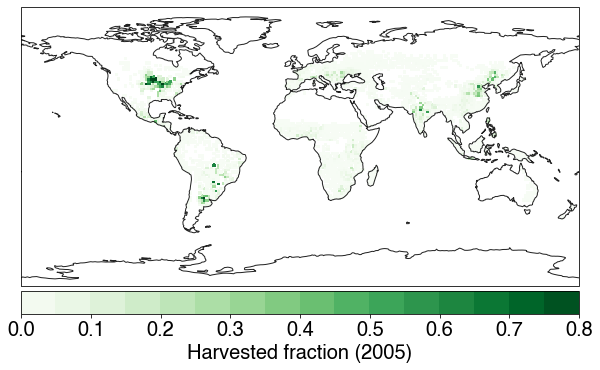

In [667]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

if region == 'us':
    ax.set_extent([-128, -67, 23, 55])
elif region == 'china':
    ax.set_extent([122, 105 , 25, 45])
elif region == 'eu':
    ax.set_extent([39, -5 , 38, 53])


v1 = 0
v2 = .81
vstep = .05
vlabelstep = .1

midnorm = MidpointNormalize(vmin=v1, vcenter=(v1+v2)/2, vmax=v2)
cmap = plt.cm.get_cmap('Greens')
c = plt.pcolormesh(era5_tasmax_max_trend.lon, era5_tasmax_max_trend.lat, crop_ha_regrid_15, cmap=cmap, norm=midnorm)
# plt.contourf(era5_t50p_trend.lon, era5_t50p_trend.lat, np.nanmedian(yearly_t50p_bias_trend_sig, axis=0), levels=[0, 0.1], colors='none', hatches=['/', ''])

if region == 'global':
    ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')
else:
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')

scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Harvested fraction (2005)', fontsize=20)

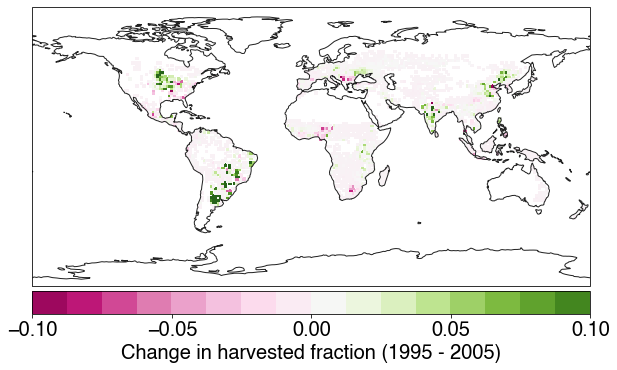

In [668]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

if region == 'us':
    ax.set_extent([-128, -67, 23, 55])
elif region == 'china':
    ax.set_extent([122, 105 , 25, 45])
elif region == 'eu':
    ax.set_extent([39, -5 , 38, 53])


v1 = -.1
v2 = .11
vstep = .0125
vlabelstep = .05

midnorm = MidpointNormalize(vmin=v1, vcenter=(v1+v2)/2, vmax=v2)
cmap = plt.cm.get_cmap('PiYG')
c = plt.pcolormesh(era5_tasmax_max_trend.lon, era5_tasmax_max_trend.lat, crop_ha_chg_regrid_15, cmap=cmap, norm=midnorm)
# plt.contourf(era5_t50p_trend.lon, era5_t50p_trend.lat, np.nanmedian(yearly_t50p_bias_trend_sig, axis=0), levels=[0, 0.1], colors='none', hatches=['/', ''])

if region == 'global':
    ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')
else:
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')

scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Change in harvested fraction (1995 - 2005)', fontsize=20)

In [669]:
# load deepak data

recalc = False

if not os.path.isfile('deepak_maize_%s.nc'%region) or recalc:
    
    maize_yield_deepak_ds = xr.Dataset()
    soy_yield_deepak_ds = xr.Dataset()

    for y, year in enumerate(range(1979, 2013+1)):
        print('processing deepak for %d...'%year)
        cur_maize_yield_deepak_ds = xr.open_dataset('%s/Maize_yield_1970_2013/Maize_areaweightedyield_%d_ver12b.nc'%(dirDeepak, year))

        lonvals = cur_maize_yield_deepak_ds['longitude'].values
        lonvals[lonvals < 0] = 360+lonvals[lonvals < 0]
        cur_maize_yield_deepak_ds['longitude'] = lonvals

        latvals = cur_maize_yield_deepak_ds['latitude'].values
        cur_maize_yield_deepak_ds['latitude'] = latvals

        cur_maize_yield_deepak_ds = cur_maize_yield_deepak_ds.rename(latitude='lat', longitude='lon')

        cur_maize_yield_deepak_ds.load()

        regridder = xe.Regridder(cur_maize_yield_deepak_ds, regridMesh, 'bilinear')
        regridder.clean_weight_file()
        cur_maize_yield_deepak_ds_regrid = regridder(cur_maize_yield_deepak_ds.Data)

        tempDs_maize_yield = xr.Dataset()
        tempDs_maize_yield['maize_yield'] = xr.DataArray(data = np.squeeze(cur_maize_yield_deepak_ds_regrid.values, axis=1), 
                              dims   = ['time', 'lat', 'lon'],
                              coords = {'time':[datetime.datetime(year,1,1)], 'lat':regridMesh['lat'], 'lon':regridMesh['lon']},
                              attrs  = {'units'     : 't/ha'
                                })

        if y == 0:
            maize_yield_deepak_ds = tempDs_maize_yield
        else:
            maize_yield_deepak_ds = xr.concat([maize_yield_deepak_ds, tempDs_maize_yield], dim='time')
        
        
        
        cur_soy_yield_deepak_ds = xr.open_dataset('%s/Soy_yield_1970_2013/Soybean_areaweightedyield_%d_ver12b.nc'%(dirDeepak, year))

        lonvals = cur_soy_yield_deepak_ds['longitude'].values
        lonvals[lonvals < 0] = 360+lonvals[lonvals < 0]
        cur_soy_yield_deepak_ds['longitude'] = lonvals

        latvals = cur_soy_yield_deepak_ds['latitude'].values
        cur_soy_yield_deepak_ds['latitude'] = latvals

        cur_soy_yield_deepak_ds = cur_soy_yield_deepak_ds.rename(latitude='lat', longitude='lon')

        cur_soy_yield_deepak_ds.load()

        regridder = xe.Regridder(cur_soy_yield_deepak_ds, regridMesh, 'bilinear')
        regridder.clean_weight_file()
        cur_soy_yield_deepak_ds_regrid = regridder(cur_soy_yield_deepak_ds.Data)

        tempDs_soy_yield = xr.Dataset()
        tempDs_soy_yield['soy_yield'] = xr.DataArray(data = np.squeeze(cur_soy_yield_deepak_ds_regrid.values, axis=1), 
                              dims   = ['time', 'lat', 'lon'],
                              coords = {'time':[datetime.datetime(year,1,1)], 'lat':regridMesh['lat'], 'lon':regridMesh['lon']},
                              attrs  = {'units'     : 't/ha'
                                })

        if y == 0:
            soy_yield_deepak_ds = tempDs_soy_yield
        else:
            soy_yield_deepak_ds = xr.concat([soy_yield_deepak_ds, tempDs_soy_yield], dim='time')
            
    maize_yield_deepak_ds.to_netcdf('deepak_maize_%s.nc'%region)
    soy_yield_deepak_ds.to_netcdf('deepak_soy_%s.nc'%region)
else:
    maize_yield_deepak_ds = xr.open_dataset('deepak_maize_%s.nc'%region)
    soy_yield_deepak_ds = xr.open_dataset('deepak_soy_%s.nc'%region)

FileNotFoundError: [Errno 2] No such file or directory: b'/smb/shared/4d8d5d/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/research/2020-ag-cmip6/deepak_soy_global.nc'

In [ ]:
maize_yield_deepak_trend = np.full([maize_yield_deepak_ds.lat.values.size, maize_yield_deepak_ds.lon.values.size], np.nan)
maize_yield_deepak_mean = np.full([maize_yield_deepak_ds.lat.values.size, maize_yield_deepak_ds.lon.values.size], np.nan)

soy_yield_deepak_trend = np.full([soy_yield_deepak_ds.lat.values.size, soy_yield_deepak_ds.lon.values.size], np.nan)
soy_yield_deepak_mean = np.full([soy_yield_deepak_ds.lat.values.size, soy_yield_deepak_ds.lon.values.size], np.nan)

for xlat in range(maize_yield_deepak_trend.shape[0]):
    for ylon in range(maize_yield_deepak_trend.shape[1]):
        
        maize_yield_deepak_mean[xlat, ylon] = np.nanmean(maize_yield_deepak_ds.maize_yield.values[:, xlat, ylon], axis=0)
        soy_yield_deepak_mean[xlat, ylon] = np.nanmean(soy_yield_deepak_ds.soy_yield.values[:, xlat, ylon], axis=0)
        
        curY = maize_yield_deepak_ds.maize_yield.values[:, xlat, ylon]
        nn = np.where((~np.isnan(curY)))[0]
        if len(nn) > 20:
            X = sm.add_constant(range(len(nn)))
            mdl = sm.OLS(curY[nn], X).fit()
            maize_yield_deepak_trend[xlat, ylon] = mdl.params[1]
            
        curY = soy_yield_deepak_ds.soy_yield.values[:, xlat, ylon]
        nn = np.where((~np.isnan(curY)))[0]
        if len(nn) > 20:
            X = sm.add_constant(range(len(nn)))
            mdl = sm.OLS(curY[nn], X).fit()
            soy_yield_deepak_trend[xlat, ylon] = mdl.params[1]

maize_yield_deepak_trend_1d = np.reshape(maize_yield_deepak_trend, [maize_yield_deepak_trend.size, 1])
maize_yield_deepak_mean_1d = np.reshape(maize_yield_deepak_mean, [maize_yield_deepak_mean.size, 1])

soy_yield_deepak_trend_1d = np.reshape(soy_yield_deepak_trend, [soy_yield_deepak_trend.size, 1])
soy_yield_deepak_mean_1d = np.reshape(soy_yield_deepak_mean, [soy_yield_deepak_mean.size, 1])

prod_trend = maize_yield_deepak_trend*maize_ha_regrid_15[-1,:,:] + soy_yield_deepak_trend*soy_ha_regrid_15[-1,:,:]
prod_trend_1d = np.reshape(prod_trend, [prod_trend.size, 1])

In [ ]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())

if region == 'us':
    ax.set_extent([-128, -67, 23, 55])
elif region == 'china':
    ax.set_extent([122, 105 , 25, 45])
elif region == 'eu':
    ax.set_extent([39, -5 , 38, 53])


v1 = -.1
v2 = .21
vstep = .0125
vlabelstep = .05

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('PiYG')
c = plt.pcolormesh(era5_tasmax_max_trend.lon, era5_tasmax_max_trend.lat, prod_trend, cmap=cmap, norm=midnorm)
# plt.contourf(era5_t50p_trend.lon, era5_t50p_trend.lat, np.nanmedian(yearly_t50p_bias_trend_sig, axis=0), levels=[0, 0.1], colors='none', hatches=['/', ''])

if region == 'global':
    ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')
else:
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')

scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Maize+soy production trend', fontsize=20)

In [ ]:
nn = np.where(abs(prod_trend_1d) > 0.01)[0]
plt.scatter(prod_trend_1d[nn], yearly_tasmax_max_bias_trend_mean_1d[nn])

In [ ]:
x=np.nanmean(cmip6_era5_tasmax_max_trend_bias, axis=0)
x=np.reshape(x,[x.size,1])
plt.scatter(crop_ha_regrid_15_1d[nn_tasmax_max], x[nn_tasmax_max])

In [ ]:
cmip6_era5_tasmax_max_trend_bias_mean = np.nanmean(cmip6_era5_tasmax_max_trend_bias, axis=0)
yearly_tasmax_max_bias_trend_mean = np.nanmean(yearly_tasmax_max_bias_trend, axis=0)
yearly_tasmax_max_bias_mean = np.nanmean(np.nanmean(yearly_tasmax_max_bias, axis=0), axis=0)

cmip6_era5_tasmax_max_trend_bias_mean_1d = cmip6_era5_tasmax_max_trend_bias_mean.reshape([cmip6_era5_tasmax_max_trend_bias_mean.size, 1])
yearly_tasmax_max_bias_trend_mean_1d = yearly_tasmax_max_bias_trend_mean.reshape([yearly_tasmax_max_bias_trend_mean.size, 1])
yearly_tasmax_max_bias_mean_1d = yearly_tasmax_max_bias_mean.reshape([yearly_tasmax_max_bias_mean.size, 1])

nn_tasmax_max = np.where((~np.isnan(crop_ha_regrid_15_1d)) & (~np.isnan(yearly_tasmax_max_bias_trend_mean_1d)) & (crop_ha_regrid_15_1d>.01) & (crop_ha_regrid_15_1d<=1))[0]

X = sm.add_constant(crop_ha_regrid_15_1d[nn_tasmax_max])
mdl_tasmax_max_bias_trend = sm.RLM(yearly_tasmax_max_bias_trend_mean_1d[nn_tasmax_max], X).fit()

X = sm.add_constant(crop_ha_regrid_15_1d[nn_tasmax_max])
mdl_tasmax_max_bias_mean = sm.RLM(yearly_tasmax_max_bias_mean_1d[nn_tasmax_max], X).fit()

X = sm.add_constant(crop_ha_regrid_15_1d[nn_tasmax_max])
mdl_tasmax_max_trend_bias = sm.RLM(cmip6_era5_tasmax_max_trend_bias_mean_1d[nn_tasmax_max], X).fit()

fig, ax = plt.subplots(1,3,figsize=(12,6))

x1 = 0
x2 = 1
ax[0].scatter(crop_ha_regrid_15_1d[nn_tasmax_max], yearly_tasmax_max_bias_trend_mean_1d[nn_tasmax_max])
ax[0].plot([x1, x2], [mdl_tasmax_max_bias_trend.params[0]+x1*mdl_tasmax_max_bias_trend.params[1], \
                    mdl_tasmax_max_bias_trend.params[0]+x2*mdl_tasmax_max_bias_trend.params[1]], '--k', lw=2)
ax[0].set_xlabel('Crop fraction')
ax[0].set_ylabel('CMIP6-ERA5 trend in TXx bias')

x1 = 0
x2 = 1
ax[1].scatter(crop_ha_regrid_15_1d[nn_tasmax_max], yearly_tasmax_max_bias_mean_1d[nn_tasmax_max])
ax[1].plot([x1, x2], [mdl_tasmax_max_bias_mean.params[0]+x1*mdl_tasmax_max_bias_mean.params[1], \
                    mdl_tasmax_max_bias_mean.params[0]+x2*mdl_tasmax_max_bias_mean.params[1]], '--k', lw=2)
ax[1].set_xlabel('Crop fraction')
ax[1].set_ylabel('CMIP6-ERA5 mean TXx bias')

x1 = 0
x2 = 1
ax[2].scatter(crop_ha_regrid_15_1d[nn_tasmax_max], cmip6_era5_tasmax_max_trend_bias_mean_1d[nn_tasmax_max])
ax[2].plot([x1, x2], [mdl_tasmax_max_trend_bias.params[0]+x1*mdl_tasmax_max_trend_bias.params[1], \
                    mdl_tasmax_max_trend_bias.params[0]+x2*mdl_tasmax_max_trend_bias.params[1]], '--k', lw=2)
ax[2].set_xlabel('Crop fraction')
ax[2].set_ylabel('CMIP6-ERA5 mean TXx trend bias')


plt.tight_layout()

In [ ]:
yearly_tasmax_max_bias_trend_mean = np.nanmean(yearly_tasmax_max_bias_trend, axis=0)
yearly_tasmax_max_bias_mean = np.nanmean(yearly_tasmax_max_bias, axis=1)

n_pos_sig_trend = 0
n_pos_sig_mean = 0

n_neg_sig_trend = 0
n_neg_sig_mean = 0

for m in range(len(cmip6_models)):
    yearly_tasmax_max_bias_trend_1d = np.reshape(yearly_tasmax_max_bias_trend[m,:,:], [yearly_tasmax_max_bias_trend[m,:,:].size, 1])
    yearly_tasmax_max_bias_mean_1d = np.reshape(yearly_tasmax_max_bias_mean[m,:,:], [yearly_tasmax_max_bias_mean[m,:,:].size, 1])
    
    nn = np.where((~np.isnan(crop_ha_regrid_15_1d)) & (~np.isnan(yearly_tasmax_max_bias_trend_1d)) & (crop_ha_regrid_15_1d>0) & (crop_ha_regrid_15_1d<1))[0]
    
    X = sm.add_constant(crop_ha_regrid_15_1d[nn])
    mdl_trend = sm.RLM(yearly_tasmax_max_bias_trend_1d[nn], X).fit()
    
    if mdl_trend.params[1] > 0 and mdl_trend.pvalues[1] <= 0.05:
        n_pos_sig_trend += 1
    elif mdl_trend.params[1] < 0 and mdl_trend.pvalues[1] <= 0.05:
        n_neg_sig_trend += 1
    
    X = sm.add_constant(crop_ha_regrid_15_1d[nn])
    mdl_mean = sm.RLM(yearly_tasmax_max_bias_mean_1d[nn], X).fit()
    
    if mdl_mean.params[1] > 0 and mdl_mean.pvalues[1] <= 0.05:
        n_pos_sig_mean += 1
    elif mdl_mean.params[1] < 0 and mdl_mean.pvalues[1] <= 0.05:
        n_neg_sig_mean += 1
    
    print('Trend: %.2f, p = %.2f \t\t Mean: %.2f, p = %.2f'%(mdl_trend.params[1], mdl_trend.pvalues[1], mdl_mean.params[1], mdl_mean.pvalues[1]))
    
print()
print(n_pos_sig_trend, n_pos_sig_mean)
print(n_neg_sig_trend, n_neg_sig_mean)